In [6]:
import os, sys

import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
plt.rc('mathtext', fontset="cm")
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
  sys.path.append(module_path)

from utils.utils import Create_Similarity_Model

sns.set_style('whitegrid')
sns.set_context("talk")

## Now we will create our model

In [2]:
n_nonsimilar = 1
n_similar = 1

### We will look for similarity in the last n_similar parameters of the inputs.

## Load the MVP data for high enough Re

In [3]:
Nr=30                #Amount of r points
Nj=5                 #Amount of j points
mr=0.01              #Minimum for r points
Mr=20                #Maximum for r points
mj=0.1               #Minimum for j points
Mj=1                 #Maximum for j points

possible_r=np.linspace(mr,Mr,Nr)
possible_j=np.linspace(mj,Mj,Nj)

In [5]:
df = pd.read_excel('../../Data/Generated Widom Data/dphi_10.xlsx')

R_ = []
J_ = []
Phi_= []
dic_x = {}
dic_y = {}

for i in range(len(possible_j)):
    possible_phi = df.iloc[:, i].values
    for k in range(len(possible_phi)):
        R_.append(possible_r[k])
        J_.append(possible_j[i])
        Phi_.append(possible_phi[k])

c = list(zip(R_, J_, Phi_))
random.shuffle(c)
R_, J_, Phi_ = zip(*c)

dic_x['j'] = J_
dic_x['r'] = R_
dic_x['phi'] = Phi_

nonsimilar_keys = ['r']

xtrain = pd.DataFrame.from_dict(dic_x)
xtrain.to_excel("Widom_Data.xlsx")

In [25]:
loss = 'mean_squared_error'
optimizer = 'adam'
best_loss = 50.0
#n_fits = 20                     # Number of model fits we will try to perform
n_fits = 1
n_epochs_initial = 1000           # Number of epochs we will train inside the loop
n_epochs_final = 10000            # Number of epochs we will train after convergence is established
successfull_tries = 0

total_tries = 0

while successfull_tries < n_fits:
    total_tries += 1
    model = Create_Similarity_Model(n_nonsimilar = n_nonsimilar, n_similar = n_similar)
    model.compile(loss = loss, optimizer = optimizer)
    model.fit(xtrain, ytrain, epochs = n_epochs_initial, verbose = 0)
    current_loss = model.evaluate(xtrain, ytrain, verbose = 0)
    print(current_loss)
    print('total tries = ' + str(total_tries))
    if current_loss < 0.01:
        successfull_tries += 1
        model.fit(xtrain, ytrain, epochs = n_epochs_final, verbose = 0)
        good_loss = model.evaluate(xtrain, ytrain, verbose = 0)
        if good_loss < best_loss:
            best_model = model
            best_loss = good_loss
    

0.01577937975525856
total tries = 1
0.01766863279044628
total tries = 2
0.0005288255051709712
total tries = 3


In [26]:
# best_model.fit(xtrain, ytrain, epochs = 10000, verbose = 0)
best_model.evaluate(xtrain, ytrain, verbose = 0)

1.5911047739791684e-05

In [27]:
for i in range(n_nonsimilar):
    similarity_exponents = best_model.get_layer('similarity_layer').weights[0][0].numpy()
    print('Exponents multiplicating inside the function for ' + nonsimilar_keys[i] + ': ' + str(similarity_exponents))

multiplication_exponents = best_model.get_layer('multiplication_layer').weights[0][0].numpy()
print('Exponents multiplicating outside the function: ' + str(multiplication_exponents))

Exponents multiplicating inside the function for r: [-0.66282237]
Exponents multiplicating outside the function: [0.33653197]


In [28]:
scaling_factor_r = -similarity_exponents
scaling_factor_phi = multiplication_exponents

r_ = []
r__ = []
phi_ = []
phi__ = []
j__ = possible_j

for i in range(len(possible_j)):
    r = possible_r
    phi = df.iloc[:, i]
    r_.append(r)
    phi_.append(phi)
    r__.append(r / (possible_j[i] ** scaling_factor_r))
    phi__.append(phi / (possible_j[i] ** scaling_factor_phi))

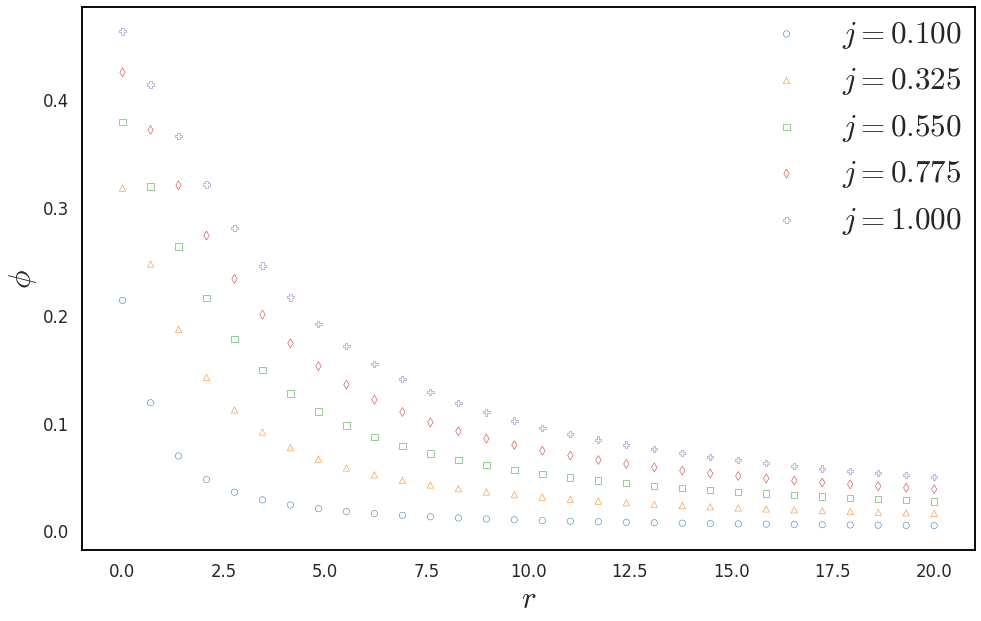

In [29]:
fig, ax1 = plt.subplots(figsize=(16, 10))

colors = matplotlib.cm.tab10(np.linspace(0, 1, 10))
markers=['o','^','s','d','P','*','v','X','<']
line_width = 0.5

j=0
for i in range(len(possible_j)):
    ax1.scatter(r_[i] , phi_[i] , s=40 , linewidth = line_width , facecolors='none', color = colors[i], marker = markers[j%len(markers)], label = r'$j = $'+r'${:.3f}$'.format(possible_j[i]))
    j+=1

font = font_manager.FontProperties(family='DejaVu Sans',
                                   weight='roman',
                                   style='normal', size = 'xx-large', stretch = 'ultra-condensed')

ax1.legend(loc = 'upper right', edgecolor = 'white', framealpha = 0, prop = font, borderaxespad=0.)
ax1.set_xlabel(r"$r$", size = 'xx-large')
ax1.set_ylabel(r'$\phi$', size = 'xx-large')
ax1.grid(False)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')
plt.savefig('Figures/Example Data for Widom.pdf', format='pdf', dpi=1200)
plt.show()

In [89]:
dic_x = {}

ranger = np.linspace(mr,Mr,Nr)
rangej = [0.1]

rtest = []
jtest = []

for r in ranger:
    for j in rangej:
        rtest.append(r)
        jtest.append(j)

dic_x['r'] = np.log(rtest)
dic_x['j'] = np.log(jtest)

xtest = pd.DataFrame.from_dict(dic_x).values
pred = np.exp(best_model.predict(xtest, verbose = 0))

(30,)

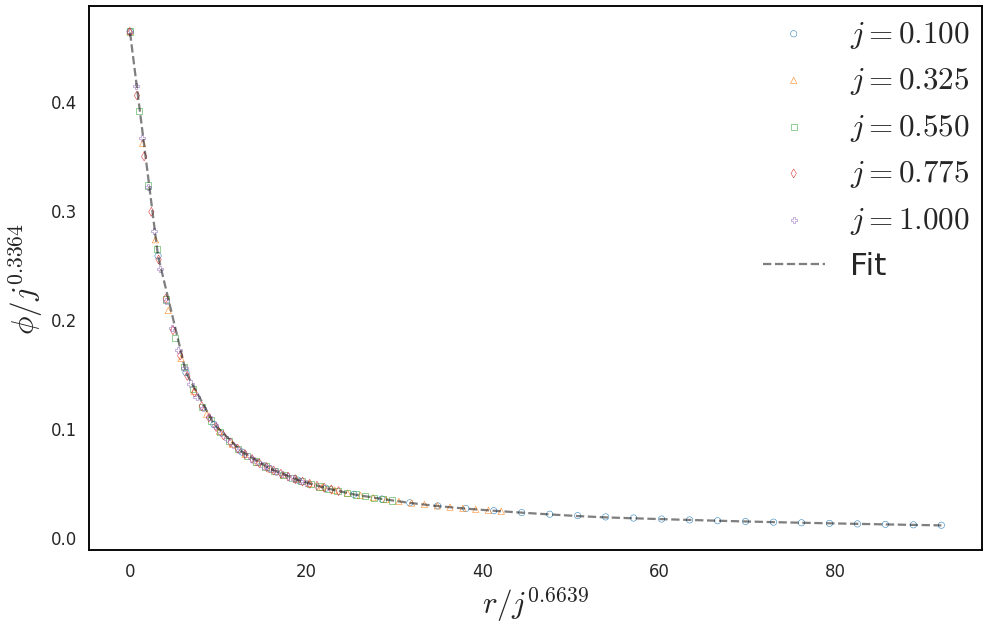

In [76]:
rtest = np.array(rtest)
jtest = np.array(jtest)

rescaled_r = list((rtest) / (jtest[0] ** (scaling_factor_r)))
rescaled_pred = list(pred / (jtest[0] ** (scaling_factor_phi)))

fig, ax1 = plt.subplots(figsize=(16, 10))

colors = matplotlib.cm.tab10(np.linspace(0, 1, 10))
markers=['o','^','s','d','P','*','v','X','<']
line_width = 0.5

j=0
for i in range(len(possible_j)):
    ax1.scatter(r__[i] , phi__[i] , s=40 , linewidth = line_width , facecolors='none', color = colors[i], marker = markers[j%len(markers)], label = r'$j = $'+r'${:.3f}$'.format(possible_j[i]))
    j+=1

ax1.plot(rescaled_r, rescaled_pred, color = 'k', alpha = 0.5, linestyle = 'dashed', label = "Fit")

font = font_manager.FontProperties(family='DejaVu Sans',
                                   weight='roman',
                                   style='normal', size = 'xx-large', stretch = 'ultra-condensed')

ax1.legend(loc = 'upper right', edgecolor = 'white', framealpha = 0, prop = font, borderaxespad=0.)
ax1.set_xlabel(r"$r/j^{0.6639}$", size = 'xx-large')
ax1.set_ylabel(r'$\phi/j^{0.3364}$', size = 'xx-large')
ax1.grid(False)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')
plt.savefig('Figures/Collapsed Data for Widom.pdf', format='pdf', dpi=1200)
plt.show()